## View 2
### Network Patterns in Average Measurements and Recorded Earthquake Characteristics
*How do different measurement calculations (`magType`) influence magnitude and depth, and how do top networks differ in their usage of measurement calculations (`magTypes`) and their average reported magnitudes/depths?*

In [1]:
import pandas as pd
import altair as alt

alt.data_transformers.disable_max_rows() # disable the "max rows = 5000" setting
alt.renderers.enable("mimetype") # to be able to view all charts in GitHub

earthquakes = pd.read_csv('../../../data/processed/ordinal_data.csv')

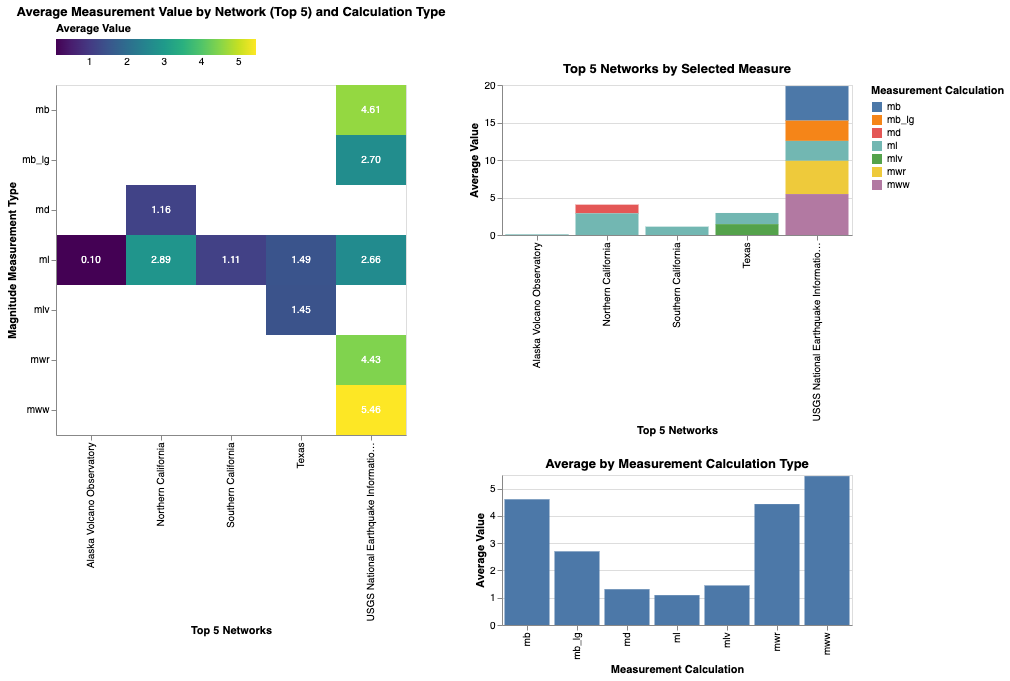

In [3]:
# ------------------
# NETWORK LABELS
# ------------------

# map network codes to full names
network_labels = {
    'av': 'Alaska Volcano Observatory',
    'ci': 'Southern California',
    'nc': 'Northern California',
    'tx': 'Texas',
    'us': 'USGS National Earthquake Information Center'
}
earthquakes['net_full'] = earthquakes['net'].map(network_labels)

# aggregate average magnitude and depth by network and magType
network_magtype_avg = earthquakes.groupby(
    ['net_full', 'magType'], as_index=False
).agg({'mag':'mean','depth':'mean'})

# melt for a column 'measure' to select dynamically
network_magtype_avg = network_magtype_avg.melt(
    id_vars=['net_full','magType'],
    value_vars=['mag','depth'],
    var_name='measure_type',
    value_name='value'
)

# aggregate average by network and magnitude measurement/calculation type
network_avg = earthquakes.groupby(['net_full', 'magType'], as_index=False).agg({'mag':'mean','depth':'mean'})
network_avg = network_avg.melt(
    id_vars=['net_full','magType'],
    value_vars=['mag','depth'],
    var_name='measure_type',
    value_name='value'
)

# ------------------
# INTERACTIONS
# ------------------

# dropdown widget to choose measure
dropdown = alt.binding_select(options=['mag','depth'], name='Measure: ')
measure_param = alt.param(value='mag', bind=dropdown)

# hover selection on magType in heatmap
hover_magtype = alt.selection_point(fields=['magType'], on='pointerover', empty=True)

# ------------------
# HEATMAP OF NETWORK x MAGTYPE BY SELECTED MEASURE (mag or depth)
# ------------------

heatmap = alt.Chart(network_magtype_avg).mark_rect().encode(
    alt.X('net_full:N', title='Top 5 Networks'),
    alt.Y('magType:N', title='Magnitude Measurement Type'),
    alt.Color('value:Q', scale=alt.Scale(scheme='viridis'), legend=alt.Legend(orient='top'), title='Average Value'),
    tooltip=['net_full:N', 'magType:N', 'value:Q']
).transform_filter(
    alt.datum.measure_type == measure_param
).add_params(
    measure_param
).add_params(
    hover_magtype
).properties(
    width=350, 
    height=350, 
    title='Average Measurement Value by Network (Top 5) and Calculation Type'
)

text = heatmap.mark_text(baseline='middle', fontSize=10).encode(
    text=alt.Text('value:Q', format=".2f"),
    color=alt.value('white')
)
heatmap = heatmap + text

# ------------------
# BAR CHART: average measure (magnitude or depth) aggregated by measurement calculation
# ------------------

avg_by_magtype = earthquakes.groupby('magType', as_index=False).agg({'mag':'mean','depth':'mean'})
avg_by_magtype = avg_by_magtype.melt(
    id_vars=['magType'],
    value_vars=['mag','depth'],
    var_name='measure_type',
    value_name='value'
)

bar_magtype = alt.Chart(avg_by_magtype).mark_bar().encode(
    alt.X('magType:N', title='Measurement Calculation'),
    alt.Y('value:Q', title='Average Value'),
    opacity=alt.condition(hover_magtype, alt.value(1.0), alt.value(0.3)),
    tooltip=['magType:N','value:Q']
).transform_filter(
    alt.datum.measure_type == measure_param
).add_params(
    measure_param
).properties(
    width=350,
    height=150,
    title='Average by Measurement Calculation Type'
)

# ------------------
# BAR CHART: average measure (magnitude or depth) per top 5 networks by measurement calculation
# ------------------

bar_network = alt.Chart(network_avg).mark_bar().encode(
    alt.X('net_full:N', title='Top 5 Networks'),
    alt.Y('value:Q', title='Average Value'),
    alt.Color('magType:N', scale=alt.Scale(scheme='tableau10'), title='Measurement Calculation'),
    opacity=alt.condition(hover_magtype, alt.value(1.0), alt.value(0.3)),
    tooltip=['net_full:N', 'magType:N', 'value:Q']
).transform_filter(
    alt.datum.measure_type == measure_param
).properties(
    width=350,
    height=150,
    title='Top 5 Networks by Selected Measure'
)

# ------------------
# FINAL LAYOUT
# ------------------
view2 = (heatmap | bar_network & bar_magtype)
view2